In [101]:
from skimage.io import imread_collection
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings(action="ignore")


In [36]:
# The test set will be used for independent validation
normal_dir = [
    'chest_xray/train/NORMAL',
    'chest_xray/val/NORMAL',
]

pneumonia_dir = [
    'chest_xray/train/PNEUMONIA',
    'chest_xray/val/PNEUMONIA'
]

In [43]:
filepaths = []
labels = []
dict_lists = [normal_dir, pneumonia_dir]
class_labels = ['NORMAL', 'PNEUMONIA']

In [44]:
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

In [45]:
file_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
pneumonia_normal_df = pd.DataFrame(pd.concat([file_series, label_series], axis=1))

In [54]:
# In the original data catalogs: train: 10432, val: 32, so we decided to use train_test_split for a better proportion.
train_df, test_df = train_test_split(pneumonia_normal_df, test_size=0.2, random_state=42, stratify=pneumonia_normal_df['label'])

In [55]:
random_index = random.randint(0, len(train_df['filepath']) - 1)
random_image = cv2.imread(train_df['filepath'].loc[random_index])
input_size = random_image.shape
print(input_size)

(936, 1304, 3)


In [79]:
image_generator = ImageDataGenerator()

train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label", 
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical'
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical'
)


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.


In [80]:
image_size=(224,224)
input_channels=3
image_shape=(image_size[0], image_size[1], input_channels)

In [81]:
model = Sequential([
    Conv2D(filters=64,
           kernel_size=(3,3),
           padding='same',
           activation='relu',
           input_shape=image_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=128,
           kernel_size=(3,3),
           padding='same',
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=256,
           kernel_size=(3,3),
           padding='same',
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=512,
           kernel_size=(3,3),
           padding='same',
           activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dropout(0.2),
    Dense(128,
          activation='relu'),
    Dropout(0.2),
    Dense(64,
          activation='relu'),
    Dropout(0.2),
    Dense(2, 
          activation='softmax')
])

In [82]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [83]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,408,386 (54.96 MB)

 Trainable params: 14,406,466 (54.96 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [106]:
#plotting model architecture
#to run
plot_model(model, to_file='model_architecture_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [108]:
#to run
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(train_generator, epochs=10, validation_data=test_generator, callbacks=[checkpoint])

Epoch 1/10
  1/210 ━━━━━━━━━━━━━━━━━━━━ 12:40 4s/step - accuracy: 1.0000 - loss: 0.0500

KeyboardInterrupt: 

In [85]:
#for 10 epochs
model.evaluate(test_generator, verbose=1)

53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 572ms/step - accuracy: 0.9340 - loss: 0.3801


[0.3508525788784027, 0.9360076189041138]

In [86]:
model.save("dl_model.h5")

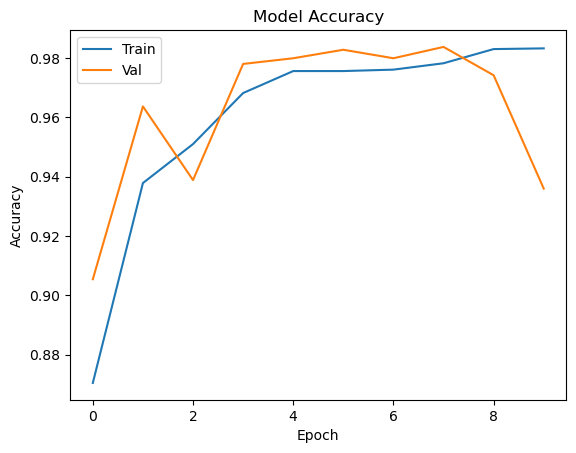

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

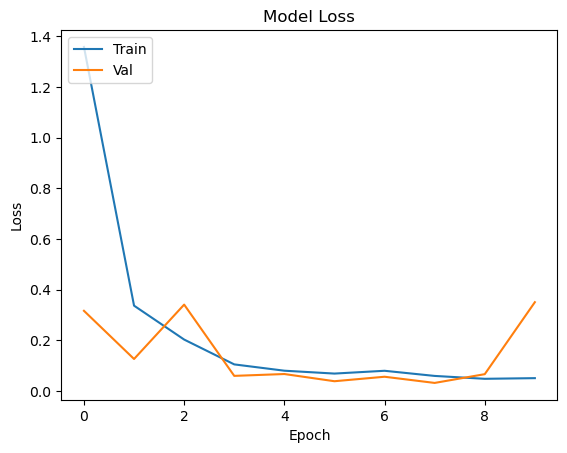

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()